In [24]:
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import numpy as np

from danial import dataloader

In [31]:
def resize_and_plot_image(input_path):
    """
    Accepts a PNG image, resizes it to 7x7 pixels, and plots the original
    and the resized image side-by-side on a graph.

    Args:
        input_path (str): The path to the input PNG image file.
    """
    try:
        # Open the original image
        original_img = Image.open(input_path)

        # Resize the image to 7x7 pixels
        resized_img = original_img.resize((7, 7), Image.LANCZOS)
        
        test = dataloader.load_image(input_path, target_size=(7, 7))

        avg_map = test.mean(dim=1, keepdim=True)  # [1, 1, 7, 7]

        # Upsample to higher resolution
        upsampled = F.interpolate(avg_map, size=(448, 448), mode='bilinear', align_corners=True)

        # Apply Gaussian blur
        blur = GaussianBlur(kernel_size=(7, 7), sigma=(1.0, 1.0))
        smoothed = blur(upsampled)

        # Load original image (keep original dimensions)
        original_img = Image.open(input_path)
        original_array = np.array(original_img)
        orig_height, orig_width = original_array.shape[:2]

        # Resize smoothed to match original image dimensions
        smoothed_resized = F.interpolate(smoothed, size=(orig_height, orig_width), mode='bilinear', align_corners=True)

        # Convert to numpy for visualization
        smoothed_np = smoothed_resized[0, 0].detach().cpu().numpy()

        # Normalize smoothed to 0-1 range for better visualization
        smoothed_normalized = (smoothed_np - smoothed_np.min()) / (smoothed_np.max() - smoothed_np.min())

        # Create a figure and two subplots (axes) side by side
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle('Original vs. 7x7 Resized Mask', fontsize=16)

        # Plot the original image on the first subplot
        axs[0].imshow(original_img)
        axs[0].set_title('Original Image')
        axs[0].axis('off')  # Hide the axes

        # Plot the resized 7x7 image on the second subplot
        axs[1].imshow(resized_img, cmap='gray') # Use a grayscale colormap for clarity
        axs[1].set_title('7x7 Resized Mask')
        axs[1].axis('off')  # Hide the axes

        # 2. Smoothed feature map (resized to original dimensions)
        im = axs[2].imshow(smoothed_normalized, cmap='jet')
        axs[2].set_title(f"Smoothed Feature Map (Resized to {orig_width}x{orig_height})", fontsize=14)
        axs[2].axis('off')
        plt.colorbar(im, ax=axs[1], fraction=0.046)

        # Adjust layout to prevent titles from overlapping
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Display the plot
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{input_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

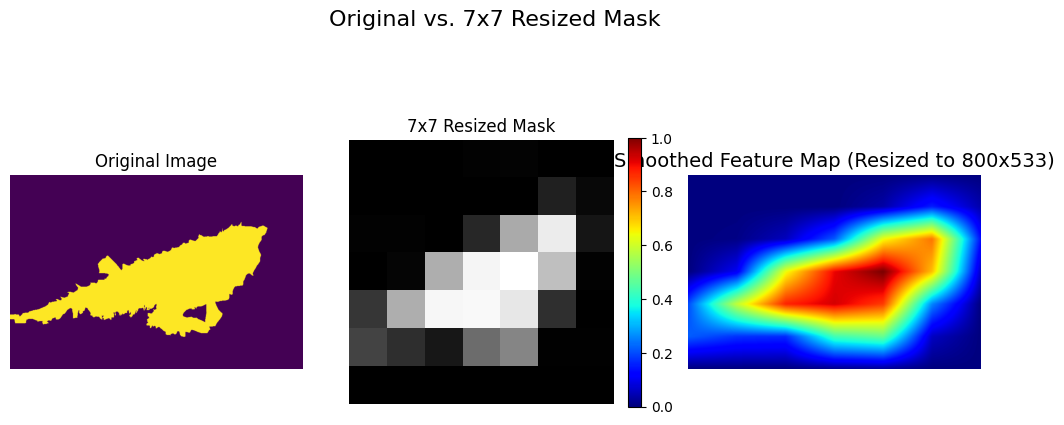

In [32]:
# Example usage:
# Assuming you have an image named 'my_image.png' in the same directory
resize_and_plot_image('test-images/masks/camo-fish-mask.png')